In [8]:
from pyspark.sql import SparkSession
import pyspark
import numpy as np
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import random

In [9]:
# Run this cell for SDSC 32 cores, 128 gb memory per node

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .config("spark.executor.memory", "6g")\
    .config("spark.executor.instances", 20)\
    .getOrCreate()

In [10]:
spark

In [11]:
# Load Cleaned CSV into Spark DataFrame

# Cluster Directory: "lmarabeh/Notebooks/cleaned_data_combined.csv"
dir = 'cleaned_data_combined.csv'
df_cleaned = spark.read.csv(dir, header=True, inferSchema=True)

In [12]:
df_cleaned.show(10)

+----------------+-----+--------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+
|recommendationid|appid|          game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|language|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|
+----------------+-----+--------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-----------------+-----------------+--------+-------

## Model 1: Helpfulness Score Regression

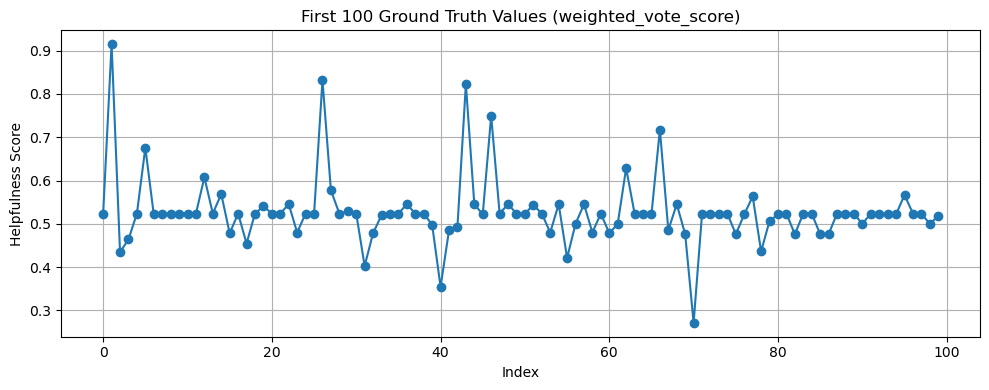

In [13]:
# Ground Truth Plot
import matplotlib.pyplot as plt

ground_truth = df_cleaned.select("weighted_vote_score").limit(100).rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 4))
plt.plot(ground_truth, marker='o')
plt.title("First 100 Ground Truth Values (weighted_vote_score)")
plt.xlabel("Index")
plt.ylabel("Helpfulness Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

numeric_cols = [
    "author_num_games_owned",
    "author_num_reviews",
    "author_playtime_forever",
    "author_playtime_last_two_weeks",
    "author_playtime_at_review",
    "author_last_played",
    "voted_up",
    "votes_up",
    "votes_funny",
    "comment_count",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access"
]

# Cast target to Double
df = df_cleaned.withColumn("label", df_cleaned["weighted_vote_score"].cast("double"))

# Assemble numeric features
assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="raw_features",
    handleInvalid="skip"
)

# Scale for better convergence
scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features",
    withMean=True,
    withStd=True
)

# Linear regression estimator
lr = LinearRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.0
)

# Build pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Regression function
def lin_reg(x):
  # Train/Test split
  train, test = df.randomSplit([x, 1-x], seed=42)

  # Fit model
  model = pipeline.fit(train)

  # Predict & evaluate
  train_predictions = model.transform(train)
  test_predictions = model.transform(test)
    
  # Plot overlay of ground truth and predictions at 0.8/0.2 train test split  
  if x == 0.8:
      pred_df = test_predictions.select("label", "prediction").limit(100).toPandas()
      plt.figure(figsize=(10,4))
      plt.plot(pred_df["label"],    marker="o", linestyle="-", label="Ground Truth")
      plt.plot(pred_df["prediction"], marker="x", linestyle="--", label="Prediction")
      plt.title("First 100: Ground Truth's vs. Model Prediction")
      plt.xlabel("Index")
      plt.ylabel("Helpfulness Score")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()
  evaluator = RegressionEvaluator(
      labelCol="label",
      predictionCol="prediction",
      metricName="rmse"
  )
  train_rmse = evaluator.evaluate(train_predictions)
  print(f"Train RMSE = {train_rmse:.4f}")
  test_rmse = evaluator.evaluate(test_predictions)
  print(f"Test RMSE = {test_rmse:.4f}")

  # Print learned coefficients
  lr_model = model.stages[-1]
  coefficients = {}
  for feature, coef in zip(numeric_cols, lr_model.coefficients):
      coefficients[feature] = coef
      print(f"{feature:>30}: {coef:.4f}")
      
  return train_rmse, test_rmse, coefficients

Starting Forward Feature Selection...
Calculating feature correlations...
Testing individual feature performance...

Feature Importance Ranking:
 1.                       votes_up: 0.2027
 2.                       voted_up: 0.1329
 3.                    votes_funny: 0.1186
 4.                  comment_count: 0.0695
 5.             author_num_reviews: 0.0669
 6.         author_num_games_owned: 0.0304
 7.      author_playtime_at_review: 0.0170
 8.                 steam_purchase: 0.0165
 9.        author_playtime_forever: 0.0146
10.    written_during_early_access: 0.0076
11.              received_for_free: 0.0054
12. author_playtime_last_two_weeks: 0.0053
13.             author_last_played: 0.0025

Forward Feature Selection Progress:
Testing model with 1 features: votes_up
  Train RMSE: 0.0694
  Test RMSE:  0.0693
  Features: ['votes_up']
----------------------------------------
Testing model with 2 features: voted_up
  Train RMSE: 0.0685
  Test RMSE:  0.0684
  Features: ['votes_up', 'vot

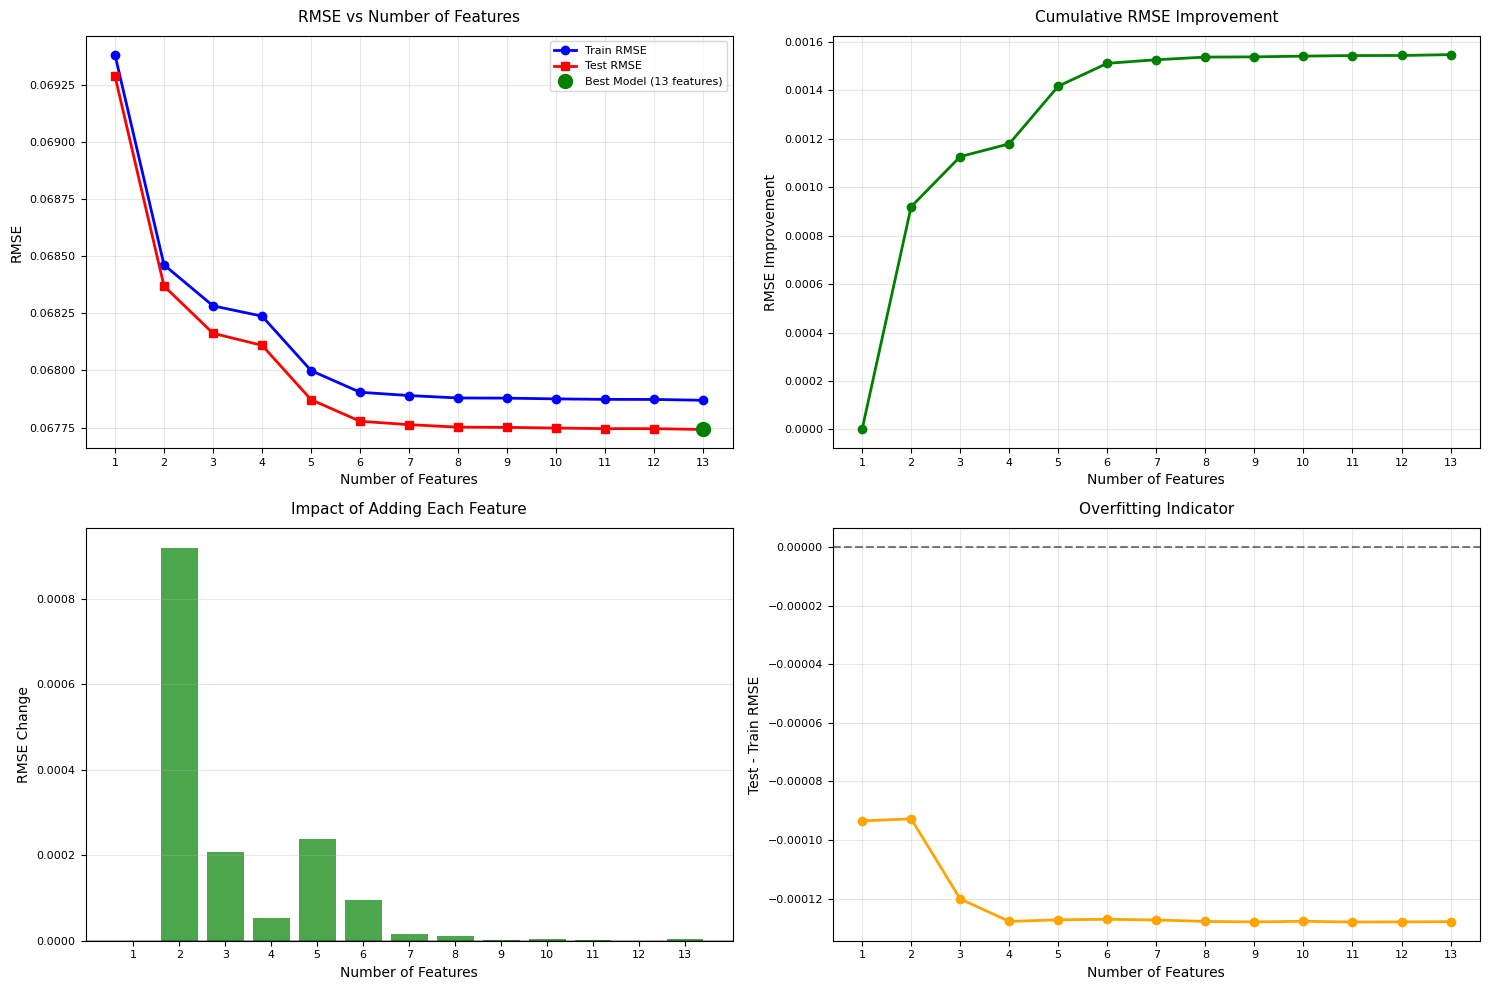

In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd
import random

# Original numeric columns
numeric_cols = [
    "author_num_games_owned",
    "author_num_reviews", 
    "author_playtime_forever",
    "author_playtime_last_two_weeks",
    "author_playtime_at_review",
    "author_last_played",
    "voted_up",
    "votes_up",
    "votes_funny",
    "comment_count",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access"
]

# Cast target to Double
df = df_cleaned.withColumn("label", df_cleaned["weighted_vote_score"].cast("double"))

def train_model_with_features(feature_subset, train_data, test_data):
    """Train a linear regression model with a specific feature subset"""
    
    # Assemble features
    assembler = VectorAssembler(
        inputCols=feature_subset,
        outputCol="raw_features",
        handleInvalid="skip"
    )
    
    # Scale features
    scaler = StandardScaler(
        inputCol="raw_features",
        outputCol="features",
        withMean=True,
        withStd=True
    )
    
    # Linear regression
    lr = LinearRegression(
        featuresCol="features",
        labelCol="label",
        maxIter=50,
        regParam=0.1,
        elasticNetParam=0.0
    )
    
    # Build and fit pipeline
    pipeline = Pipeline(stages=[assembler, scaler, lr])
    model = pipeline.fit(train_data)
    
    # Make predictions
    train_predictions = model.transform(train_data)
    test_predictions = model.transform(test_data)
    
    # Evaluate
    evaluator = RegressionEvaluator(
        labelCol="label",
        predictionCol="prediction", 
        metricName="rmse"
    )
    
    train_rmse = evaluator.evaluate(train_predictions)
    test_rmse = evaluator.evaluate(test_predictions)
    
    # Get coefficients
    lr_model = model.stages[-1]
    coefficients = {}
    for feature, coef in zip(feature_subset, lr_model.coefficients):
        coefficients[feature] = coef
    
    return {
        'features': feature_subset,
        'num_features': len(feature_subset),
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'coefficients': coefficients,
        'model': model
    }

def generate_feature_combinations(all_features, min_features=1, max_features=None):
    """Generate all combinations of features within specified range"""
    if max_features is None:
        max_features = len(all_features)
    
    combinations_list = []
    for r in range(min_features, max_features + 1):
        for combo in combinations(all_features, r):
            combinations_list.append(list(combo))
    
    return combinations_list

def rank_features_by_importance(train_data):
    """
    Rank features by their individual correlation with the target
    and univariate model performance
    """
    from pyspark.sql.functions import corr
    
    feature_scores = {}
    
    # Method 1: Correlation with target
    print("Calculating feature correlations...")
    for feature in numeric_cols:
        try:
            correlation = train_data.select(corr(feature, "label")).collect()[0][0]
            if correlation is not None:
                feature_scores[feature] = abs(correlation)
            else:
                feature_scores[feature] = 0.0
        except:
            feature_scores[feature] = 0.0
    
    # Method 2: Individual univariate model performance
    print("Testing individual feature performance...")
    for feature in numeric_cols:
        try:
            result = train_model_with_features([feature], train_data, train_data)
            # Use negative RMSE so higher is better (for consistent ranking)
            univariate_score = -result['test_rmse']
            # Combine correlation and univariate performance
            combined_score = 0.7 * feature_scores[feature] + 0.3 * (univariate_score / 10)
            feature_scores[feature] = combined_score
        except:
            # Keep correlation score if univariate model fails
            pass
    
    # Sort features by importance (highest score first)
    ranked_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
    
    print("\nFeature Importance Ranking:")
    for i, (feature, score) in enumerate(ranked_features, 1):
        print(f"{i:2d}. {feature:>30}: {score:.4f}")
    
    return [feature for feature, score in ranked_features]

def forward_feature_selection(train_test_split=0.8):
    """
    Perform forward feature selection: add features one by one in order of importance
    """
    # Train/Test split
    train, test = df.randomSplit([train_test_split, 1-train_test_split], seed=42)
    
    # Rank features by importance
    ranked_features = rank_features_by_importance(train)
    
    results = []
    selected_features = []
    
    print("\nForward Feature Selection Progress:")
    print("="*60)
    
    # Add features one by one
    for i, feature in enumerate(ranked_features, 1):
        selected_features.append(feature)
        
        print(f"Testing model with {i} features: {selected_features[-1]}")
        
        try:
            result = train_model_with_features(selected_features.copy(), train, test)
            results.append(result)
            
            print(f"  Train RMSE: {result['train_rmse']:.4f}")
            print(f"  Test RMSE:  {result['test_rmse']:.4f}")
            print(f"  Features: {result['features']}")
            print("-" * 40)
            
        except Exception as e:
            print(f"  Error: {e}")
            # Remove the problematic feature and continue
            selected_features.pop()
            continue
    
    return results, ranked_features

def plot_forward_selection_results(results):
    """
    Create plots specifically for forward feature selection results with proper text sizing
    """
    if not results:
        print("No results to plot!")
        return
    
    # Extract data
    num_features = [r['num_features'] for r in results]
    train_rmse = [r['train_rmse'] for r in results]
    test_rmse = [r['test_rmse'] for r in results]
    
    # Create figure with more space between subplots
    plt.figure(figsize=(15, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    # Main plot: RMSE vs Number of Features
    plt.subplot(2, 2, 1)
    plt.plot(num_features, train_rmse, 'o-', color='blue', label='Train RMSE', linewidth=2, markersize=6)
    plt.plot(num_features, test_rmse, 's-', color='red', label='Test RMSE', linewidth=2, markersize=6)
    
    # Find and mark the best model
    best_idx = min(range(len(test_rmse)), key=lambda i: test_rmse[i])
    plt.plot(num_features[best_idx], test_rmse[best_idx], 'o', color='green', 
             markersize=10, label=f'Best Model ({num_features[best_idx]} features)')
    
    plt.xlabel('Number of Features', fontsize=10)
    plt.ylabel('RMSE', fontsize=10)
    plt.title('RMSE vs Number of Features', fontsize=11, pad=10)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.xticks(num_features, fontsize=8)
    plt.yticks(fontsize=8)
    
    # Plot 2: RMSE Improvement
    plt.subplot(2, 2, 2)
    if len(test_rmse) > 1:
        rmse_improvement = [test_rmse[0] - rmse for rmse in test_rmse]
        plt.plot(num_features, rmse_improvement, 'o-', color='green', linewidth=2, markersize=6)
        plt.xlabel('Number of Features', fontsize=10)
        plt.ylabel('RMSE Improvement', fontsize=10)
        plt.title('Cumulative RMSE Improvement', fontsize=11, pad=10)
        plt.grid(True, alpha=0.3)
        plt.xticks(num_features, fontsize=8)
        plt.yticks(fontsize=8)
    
    # Plot 3: Feature Addition Impact
    plt.subplot(2, 2, 3)
    if len(test_rmse) > 1:
        rmse_delta = [0] + [test_rmse[i-1] - test_rmse[i] for i in range(1, len(test_rmse))]
        colors = ['green' if delta > 0 else 'red' for delta in rmse_delta]
        bars = plt.bar(num_features, rmse_delta, color=colors, alpha=0.7)
        plt.xlabel('Number of Features', fontsize=10)
        plt.ylabel('RMSE Change', fontsize=10)
        plt.title('Impact of Adding Each Feature', fontsize=11, pad=10)
        plt.grid(True, alpha=0.3, axis='y')
        plt.xticks(num_features, fontsize=8)
        plt.yticks(fontsize=8)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Plot 4: Train vs Test RMSE Difference (Overfitting indicator)
    plt.subplot(2, 2, 4)
    rmse_diff = [test - train for test, train in zip(test_rmse, train_rmse)]
    plt.plot(num_features, rmse_diff, 'o-', color='orange', linewidth=2, markersize=6)
    plt.xlabel('Number of Features', fontsize=10)
    plt.ylabel('Test - Train RMSE', fontsize=10)
    plt.title('Overfitting Indicator', fontsize=11, pad=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(num_features, fontsize=8)
    plt.yticks(fontsize=8)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()

def analyze_best_feature_subset(results):
    """
    Analyze and recommend the best number of features based on various criteria
    """
    if not results:
        return
    
    test_rmse = [r['test_rmse'] for r in results]
    num_features = [r['num_features'] for r in results]
    
    # Find best model by test RMSE
    best_idx = min(range(len(test_rmse)), key=lambda i: test_rmse[i])
    best_rmse = test_rmse[best_idx]
    best_num_features = num_features[best_idx]
    
    print("\n" + "="*60)
    print("FORWARD FEATURE SELECTION ANALYSIS")
    print("="*60)
    
    print(f"\nBest Model:")
    print(f"  Number of features: {best_num_features}")
    print(f"  Test RMSE: {best_rmse:.4f}")
    print(f"  Features: {results[best_idx]['features']}")
    
    # Find elbow point (where improvement starts to plateau)
    if len(test_rmse) > 2:
        improvements = [test_rmse[0] - rmse for rmse in test_rmse]
        deltas = [improvements[i] - improvements[i-1] if i > 0 else improvements[i] 
                 for i in range(len(improvements))]
        
        # Find where improvement rate drops significantly
        for i in range(1, len(deltas)):
            if deltas[i] < 0.1 * deltas[1]:  # Less than 10% of initial improvement
                elbow_point = i + 1
                break
        else:
            elbow_point = best_num_features
        
        print(f"\nRecommended number of features (elbow point): {elbow_point}")
        print(f"Recommended features: {results[elbow_point-1]['features']}")
    
    # Show performance at different feature counts
    print(f"\nPerformance Summary:")
    for i, result in enumerate(results):
        improvement = test_rmse[0] - result['test_rmse']
        print(f"  {result['num_features']:2d} features: Test RMSE = {result['test_rmse']:.4f} "
              f"(improvement: {improvement:.4f})")

# Modified main execution
print("Starting Forward Feature Selection...")

# Perform forward feature selection
forward_results, feature_ranking = forward_feature_selection(train_test_split=0.8)

# Analyze results
analyze_best_feature_subset(forward_results)

# Create plots
print("\nCreating forward selection plots...")
plot_forward_selection_results(forward_results)

In [ ]:
train_rmse_history = []
test_rmse_history = []
coefficients_history = []
x = [0.1, 0.2, 0.5, 0.8, 0.9]

for train_size in x:
  print(f"RMSE Values for train size {train_size}")
  train_rmse, test_rmse, coefficients = lin_reg(train_size)
  train_rmse_history.append(train_rmse)
  test_rmse_history.append(test_rmse)
  coefficients_history.append(coefficients)

print("\nTraining RMSE values:", train_rmse_history)
print("Testing RMSE values:", test_rmse_history)
print("Coefficients for each train size:", coefficients_history)

In [ ]:
plt.plot(x, train_rmse_history, 'o-', color="r", label="Training RMSE")
plt.plot(x, test_rmse_history, 'o-', color="g", label="Test RMSE")
plt.xlabel("Fraction of Training Data")
plt.ylabel("RMSE")
plt.title("Fitting Curve for Linear Regression")
plt.legend(loc="best")
plt.grid(True)
plt.show()